# Volatility Prediction

In [11]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [12]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [13]:
ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

- 2010-2021년 기간 동안 S&P 500의 실현 변동성을 보여준다
- 코로나 19 사태를 둘러싼 급증이 보인다.

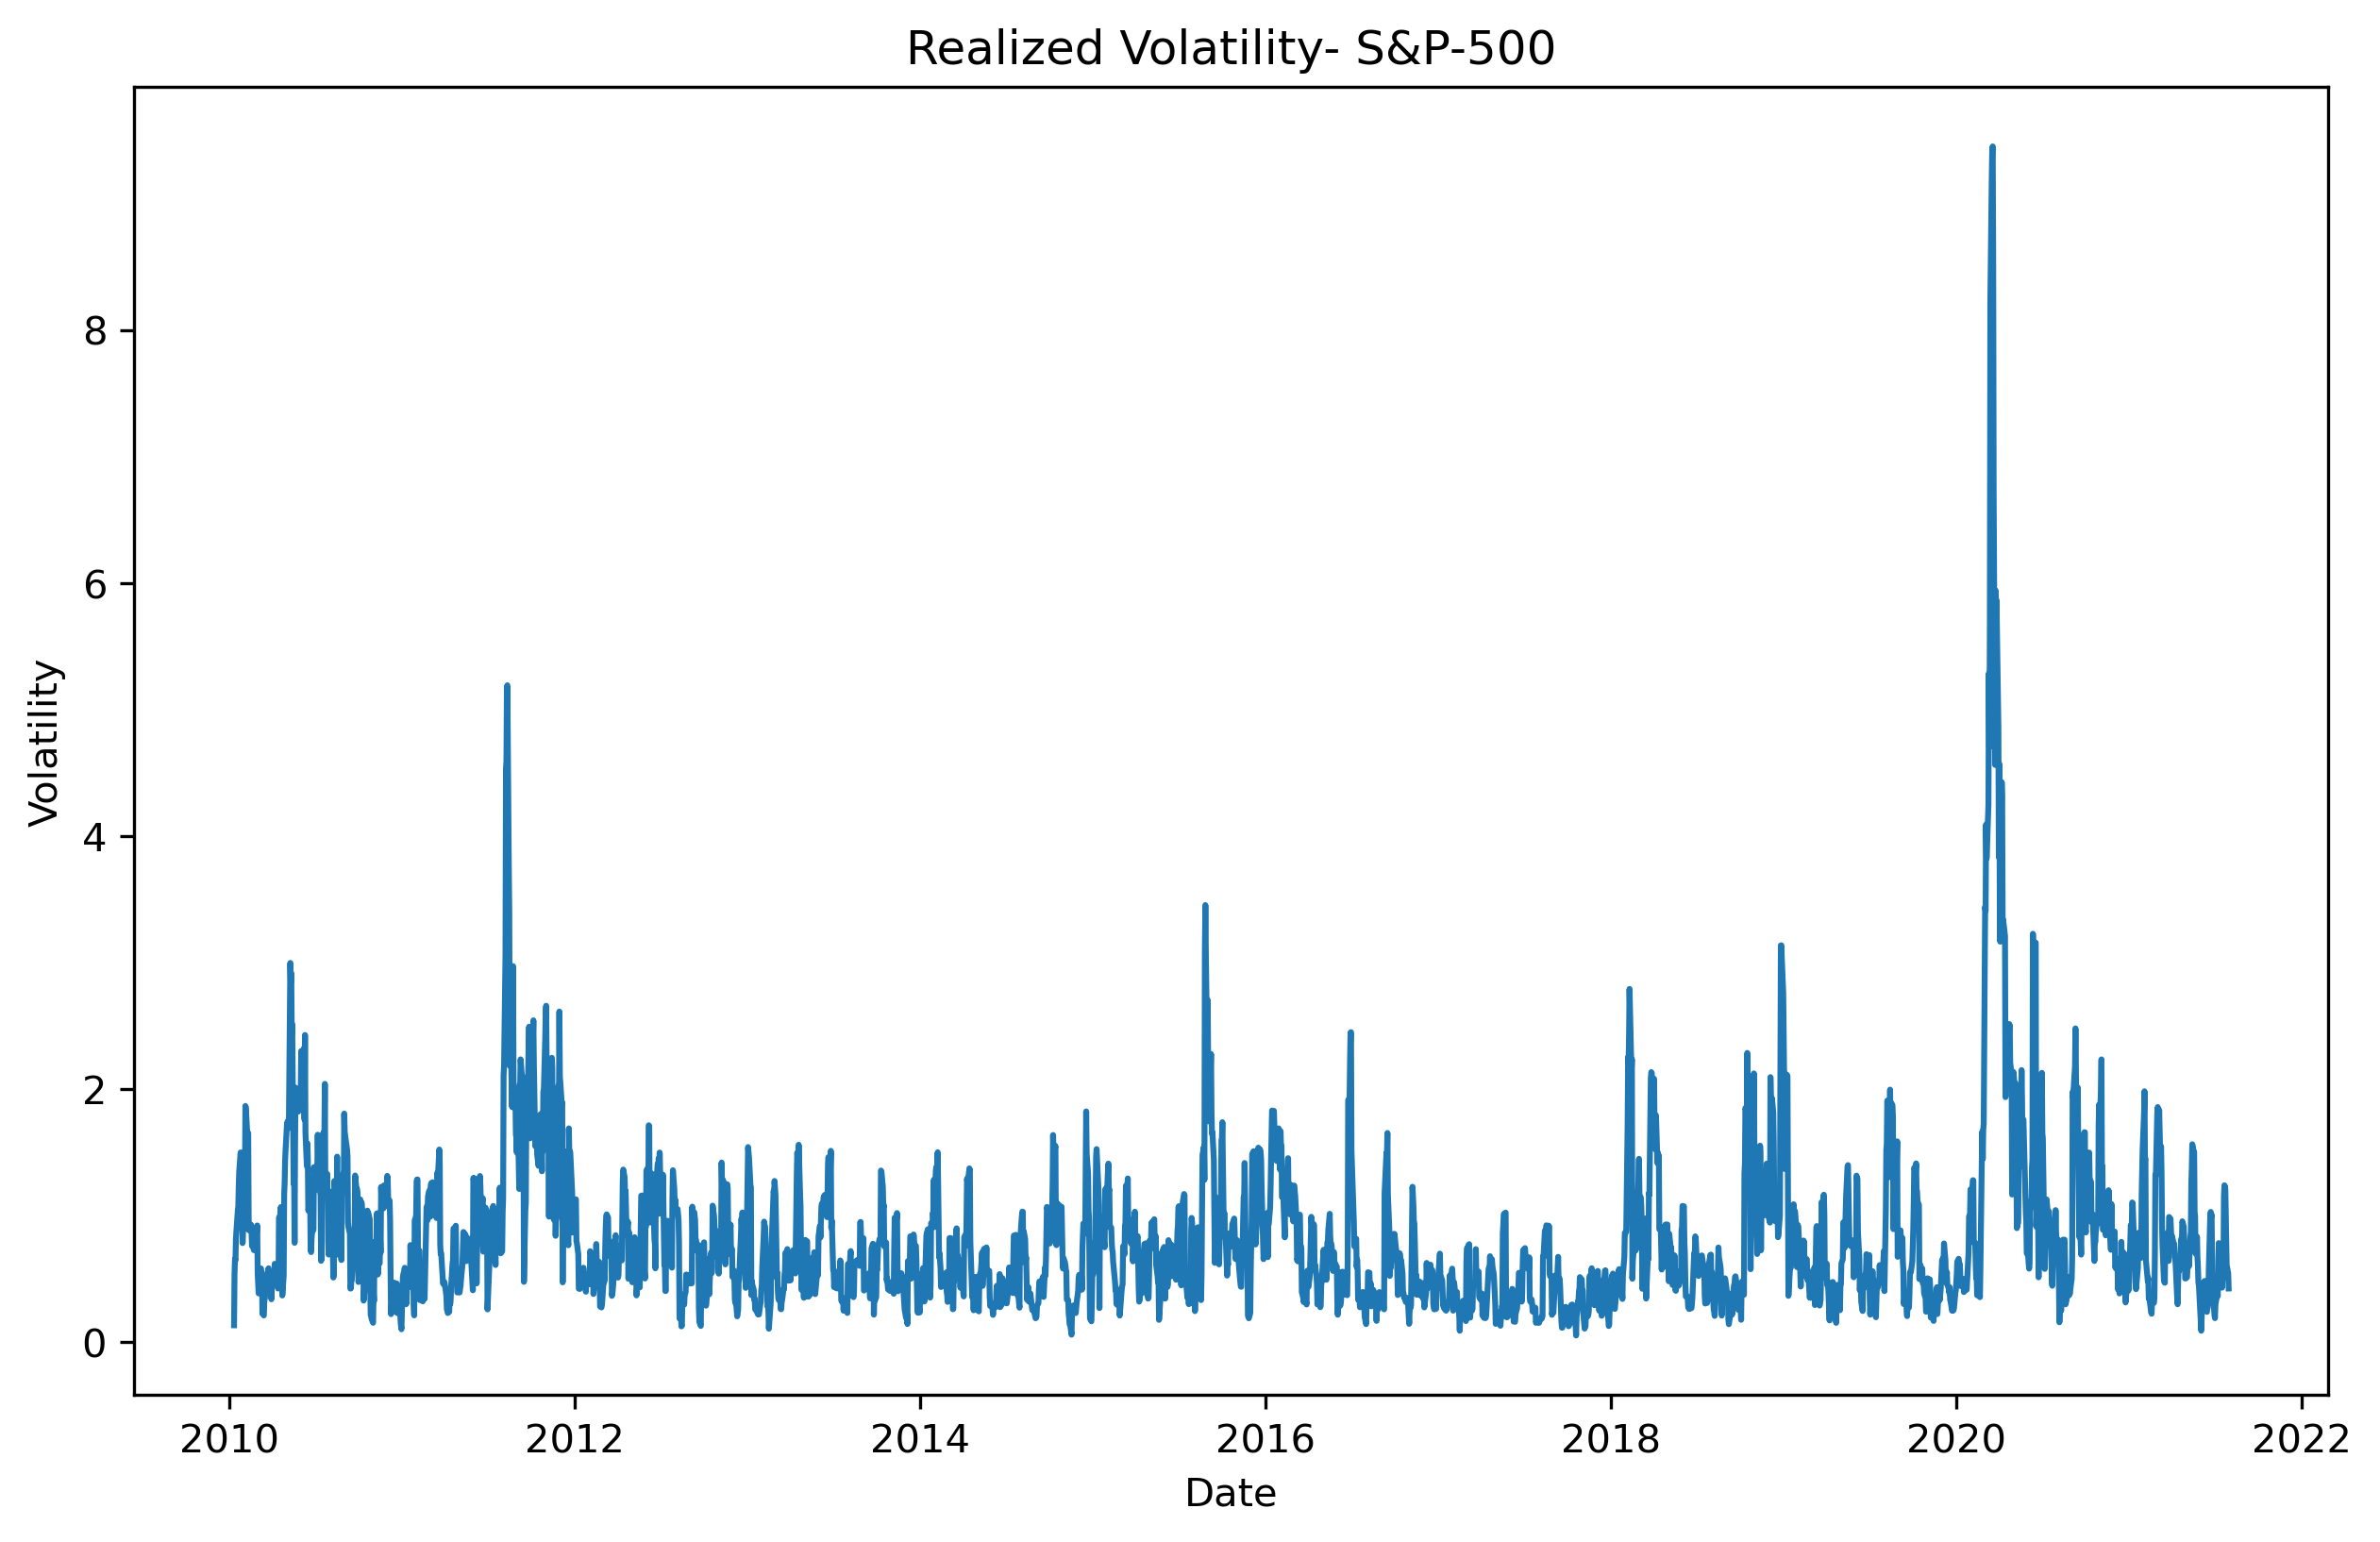

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500') 
plt.ylabel('Volatility')
plt.xlabel('Date') 
plt.show()

In [15]:
retv = ret.values

- 변동성이 클러스터링이 되어 이동하는 것을 볼 수 있다.

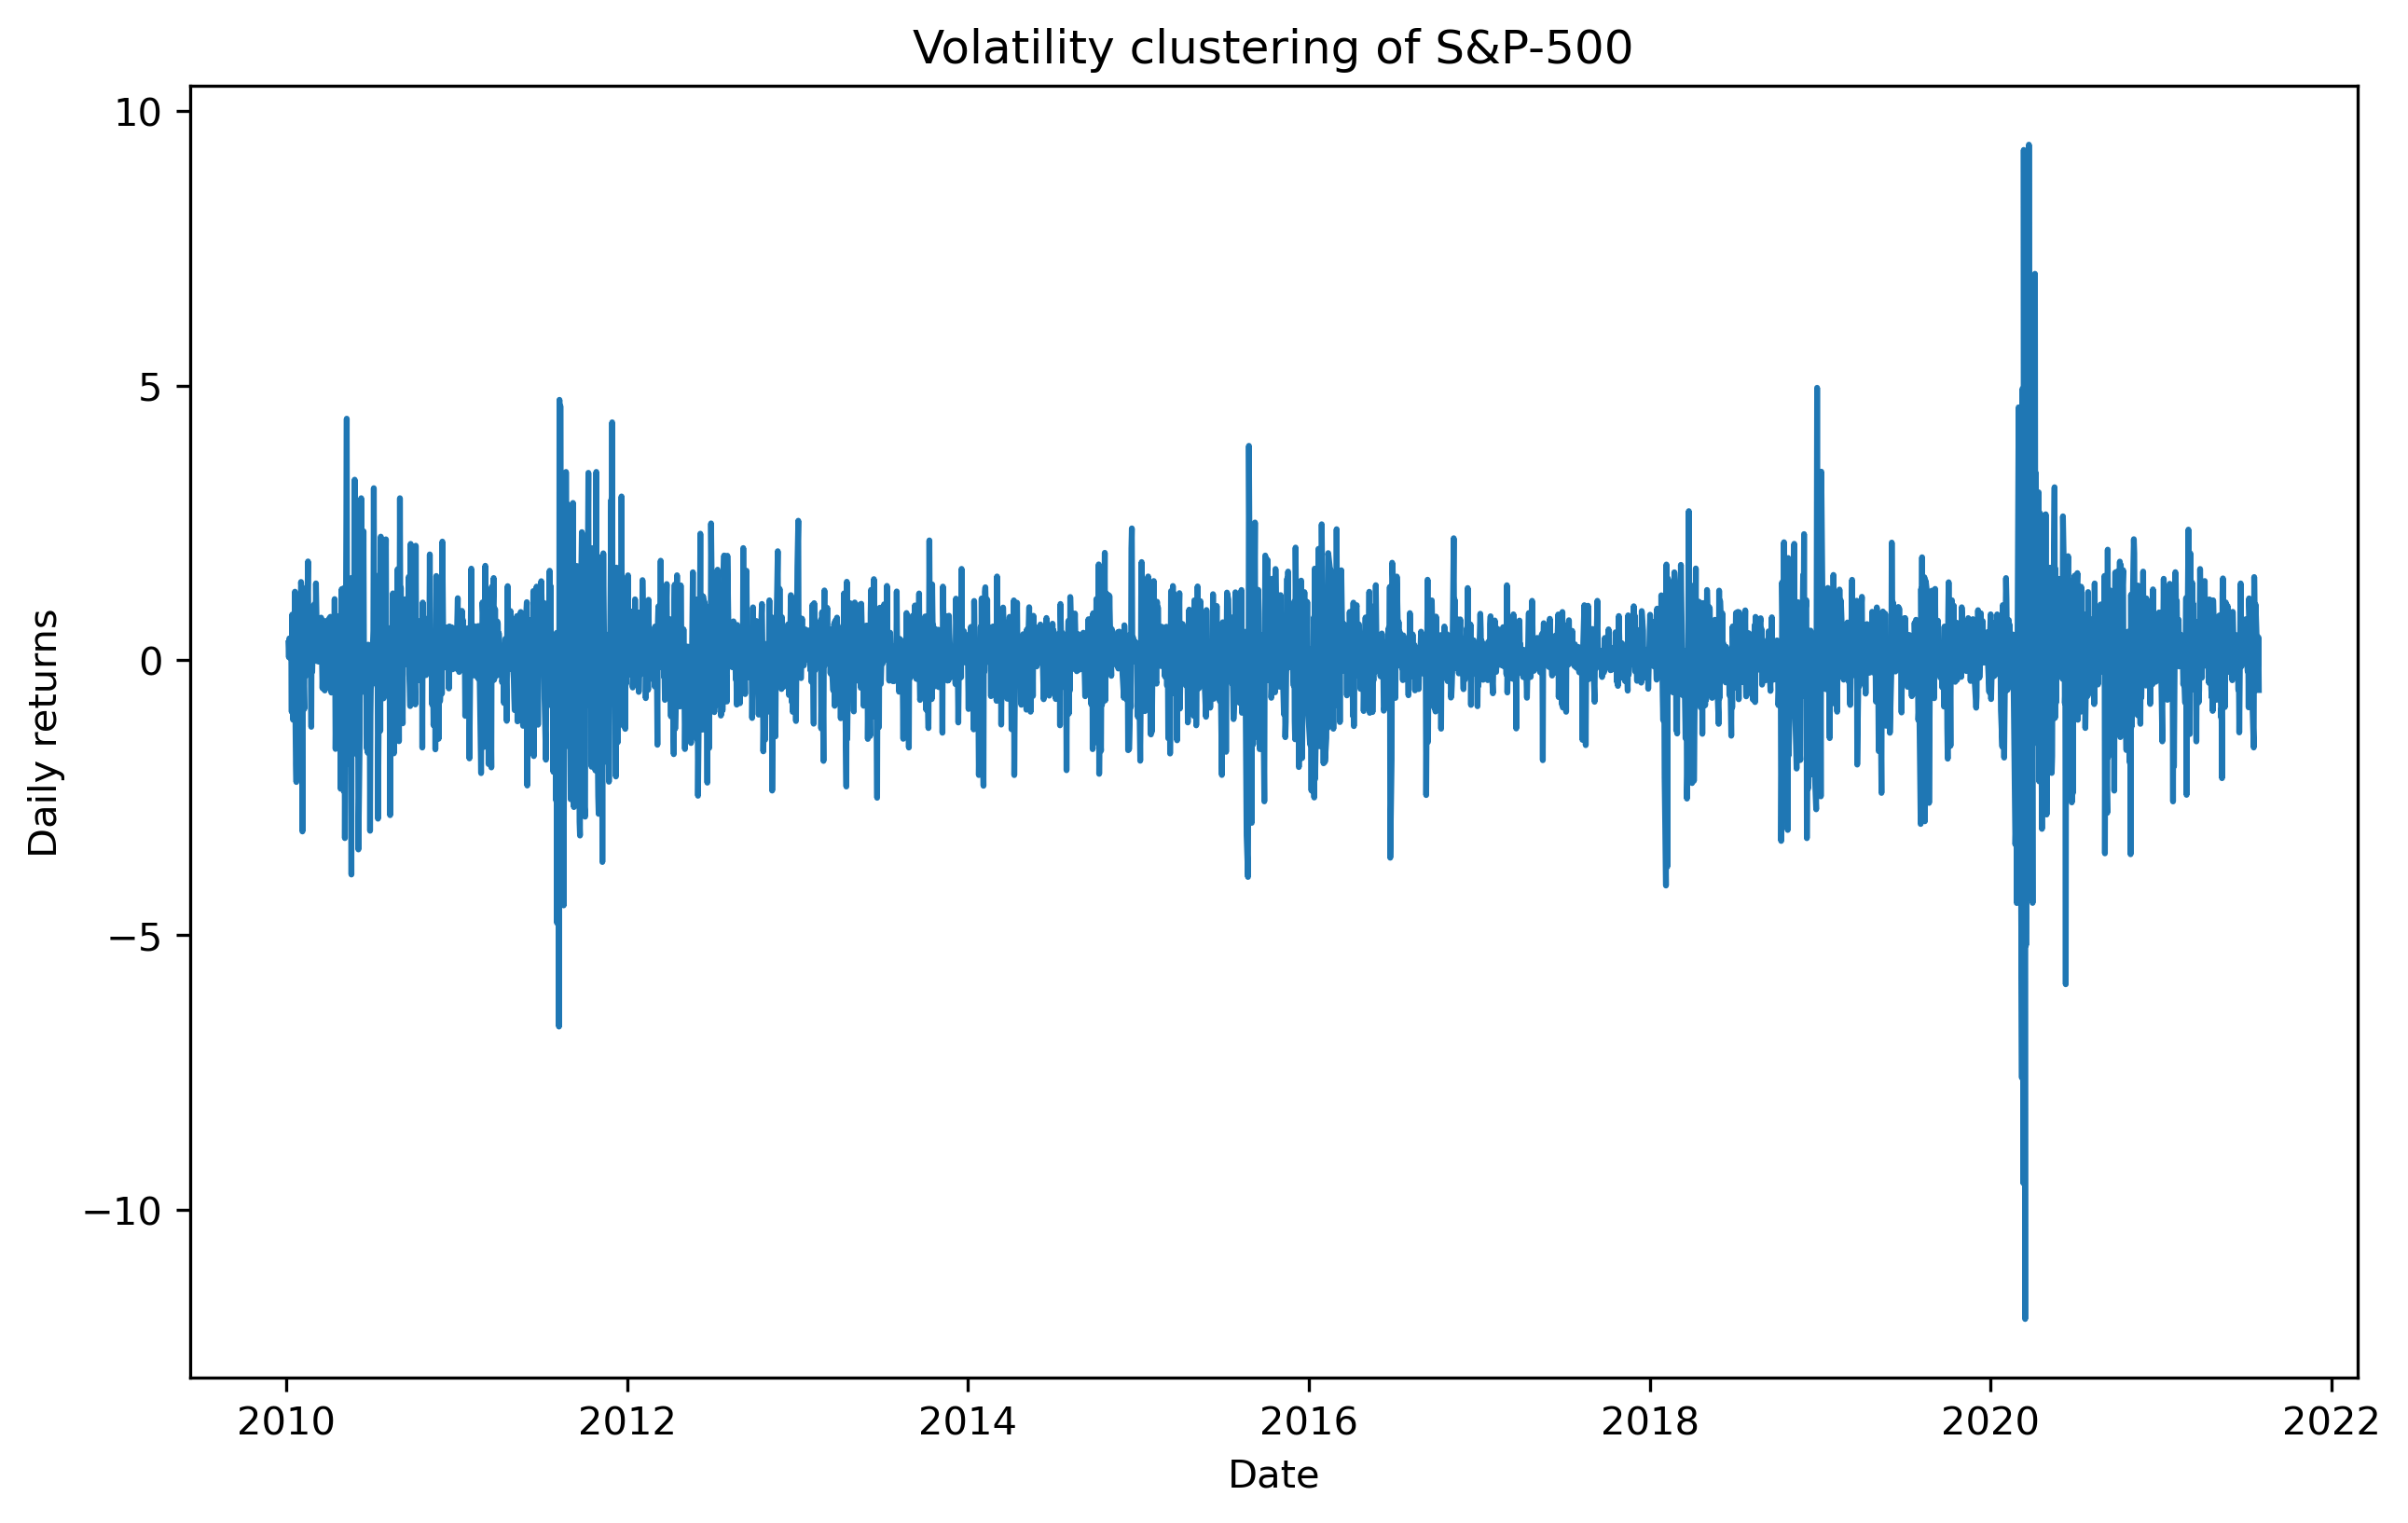

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500') 
plt.ylabel('Daily returns')
plt.xlabel('Date') 
plt.show()

# 고전적인 변동성 모델
1. ARCH
2. GARCH
3. GJR-GARCH
4. EGARCH

## ARCH: Autoregressive Conditional Heteroskedasticity

- ARCH는 일변량 모델이며 과거 자산 수익률을 기반으로 한다.  
- 시간에 따라 변하는 조건부 분산의 속성을 가지고 있다.
- 이로 인해 ARCH는변동성 클러스터링으로 알려진 현상을 모델링 할 수 있다.
- 작은 변화는 대개 작은 변화 뒤에 오는 경향이 있고 큰 변화는 뒤에 발생하는 경향이 있다.
- 따라서, 시장에 중요한 발표가 나면 큰 변동성을 초래할 수 있다.

$\sigma_t^2 = \omega + \sum_{k=1}^{p} \alpha_k (r_{t-k})^{2}
\  $
$r_{t} = \sigma_{t} \varepsilon_{t}$

$\omega > 0$

$\alpha_k \geq 0\$


#### ARCH 단점
- 양 및 음으 충격에 대해 동일하게 반응한다.
- 매개변수 제한과 같은 강력한 가정이 필요하다.
- 큰 움직임에 대한 느린 조정으로 인한 잘못된 예측 가능성이 있다.

### arch 모델 사용하는 버전
- 모델과 지연을 정하기 위해 BIC를 선택한다. Bayesian Information Criterion(베이지안 정보 기준)

$BIC = n \cdot \ln(\hat{\sigma}^2) + k \cdot \ln(n)\$

여기서,
- \( n \)은 관찰된 데이터의 개다
- $( \hat{\sigma}^2$\)은 모델에서 추정한 조건부 니다.
- \( k \)는 모델의 매개변수 수(자입니다.

In [19]:
n = 252
split_date = ret.iloc[-n:].index

In [20]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4061.27
Distribution:                  Normal   AIC:                           8126.54
Method:            Maximum Likelihood   BIC:                           8138.50
                                        No. Observations:                 2913
Date:                Fri, Dec 08 2023   Df Residuals:                     2913
Time:                        20:22:37   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7014  5.002e-02     14.023  1.129e-44 [  0.603,  0.79

In [21]:
bic_arch = []

for p in range(1, 5): #지정된 구간 동안 ARCH 매개변수 p 반복
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
                .fit(disp='off') #다른 p 값으로 ARCH 모델 실행
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):  #최적의 모델을 선택하기 위한 최소 BIC 점수 찾기
            best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
        .fit(disp='off')  #최고의 p값으로 ARCH 모델 실행
print(arch.summary())
forecast = arch.forecast(start=split_date[0])  #최적화된 ARHC 모델을 기반으로 변동성 예측
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3709.51
Distribution:                  Normal   AIC:                           7429.03
Method:            Maximum Likelihood   BIC:                           7458.91
                                        No. Observations:                 2913
Date:                Fri, Dec 08 2023   Df Residuals:                     2913
Time:                        20:22:38   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2794  2.580e-02     10.829  2.498e-27   [  0.22

In [22]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, 
                        np.sqrt(forecast_arch\
                        .variance.iloc[-len(split_date):] 
                        / 100))) #RMSE 점수 계산
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0896


- ARCH 모델을 사용한 변동성 예측

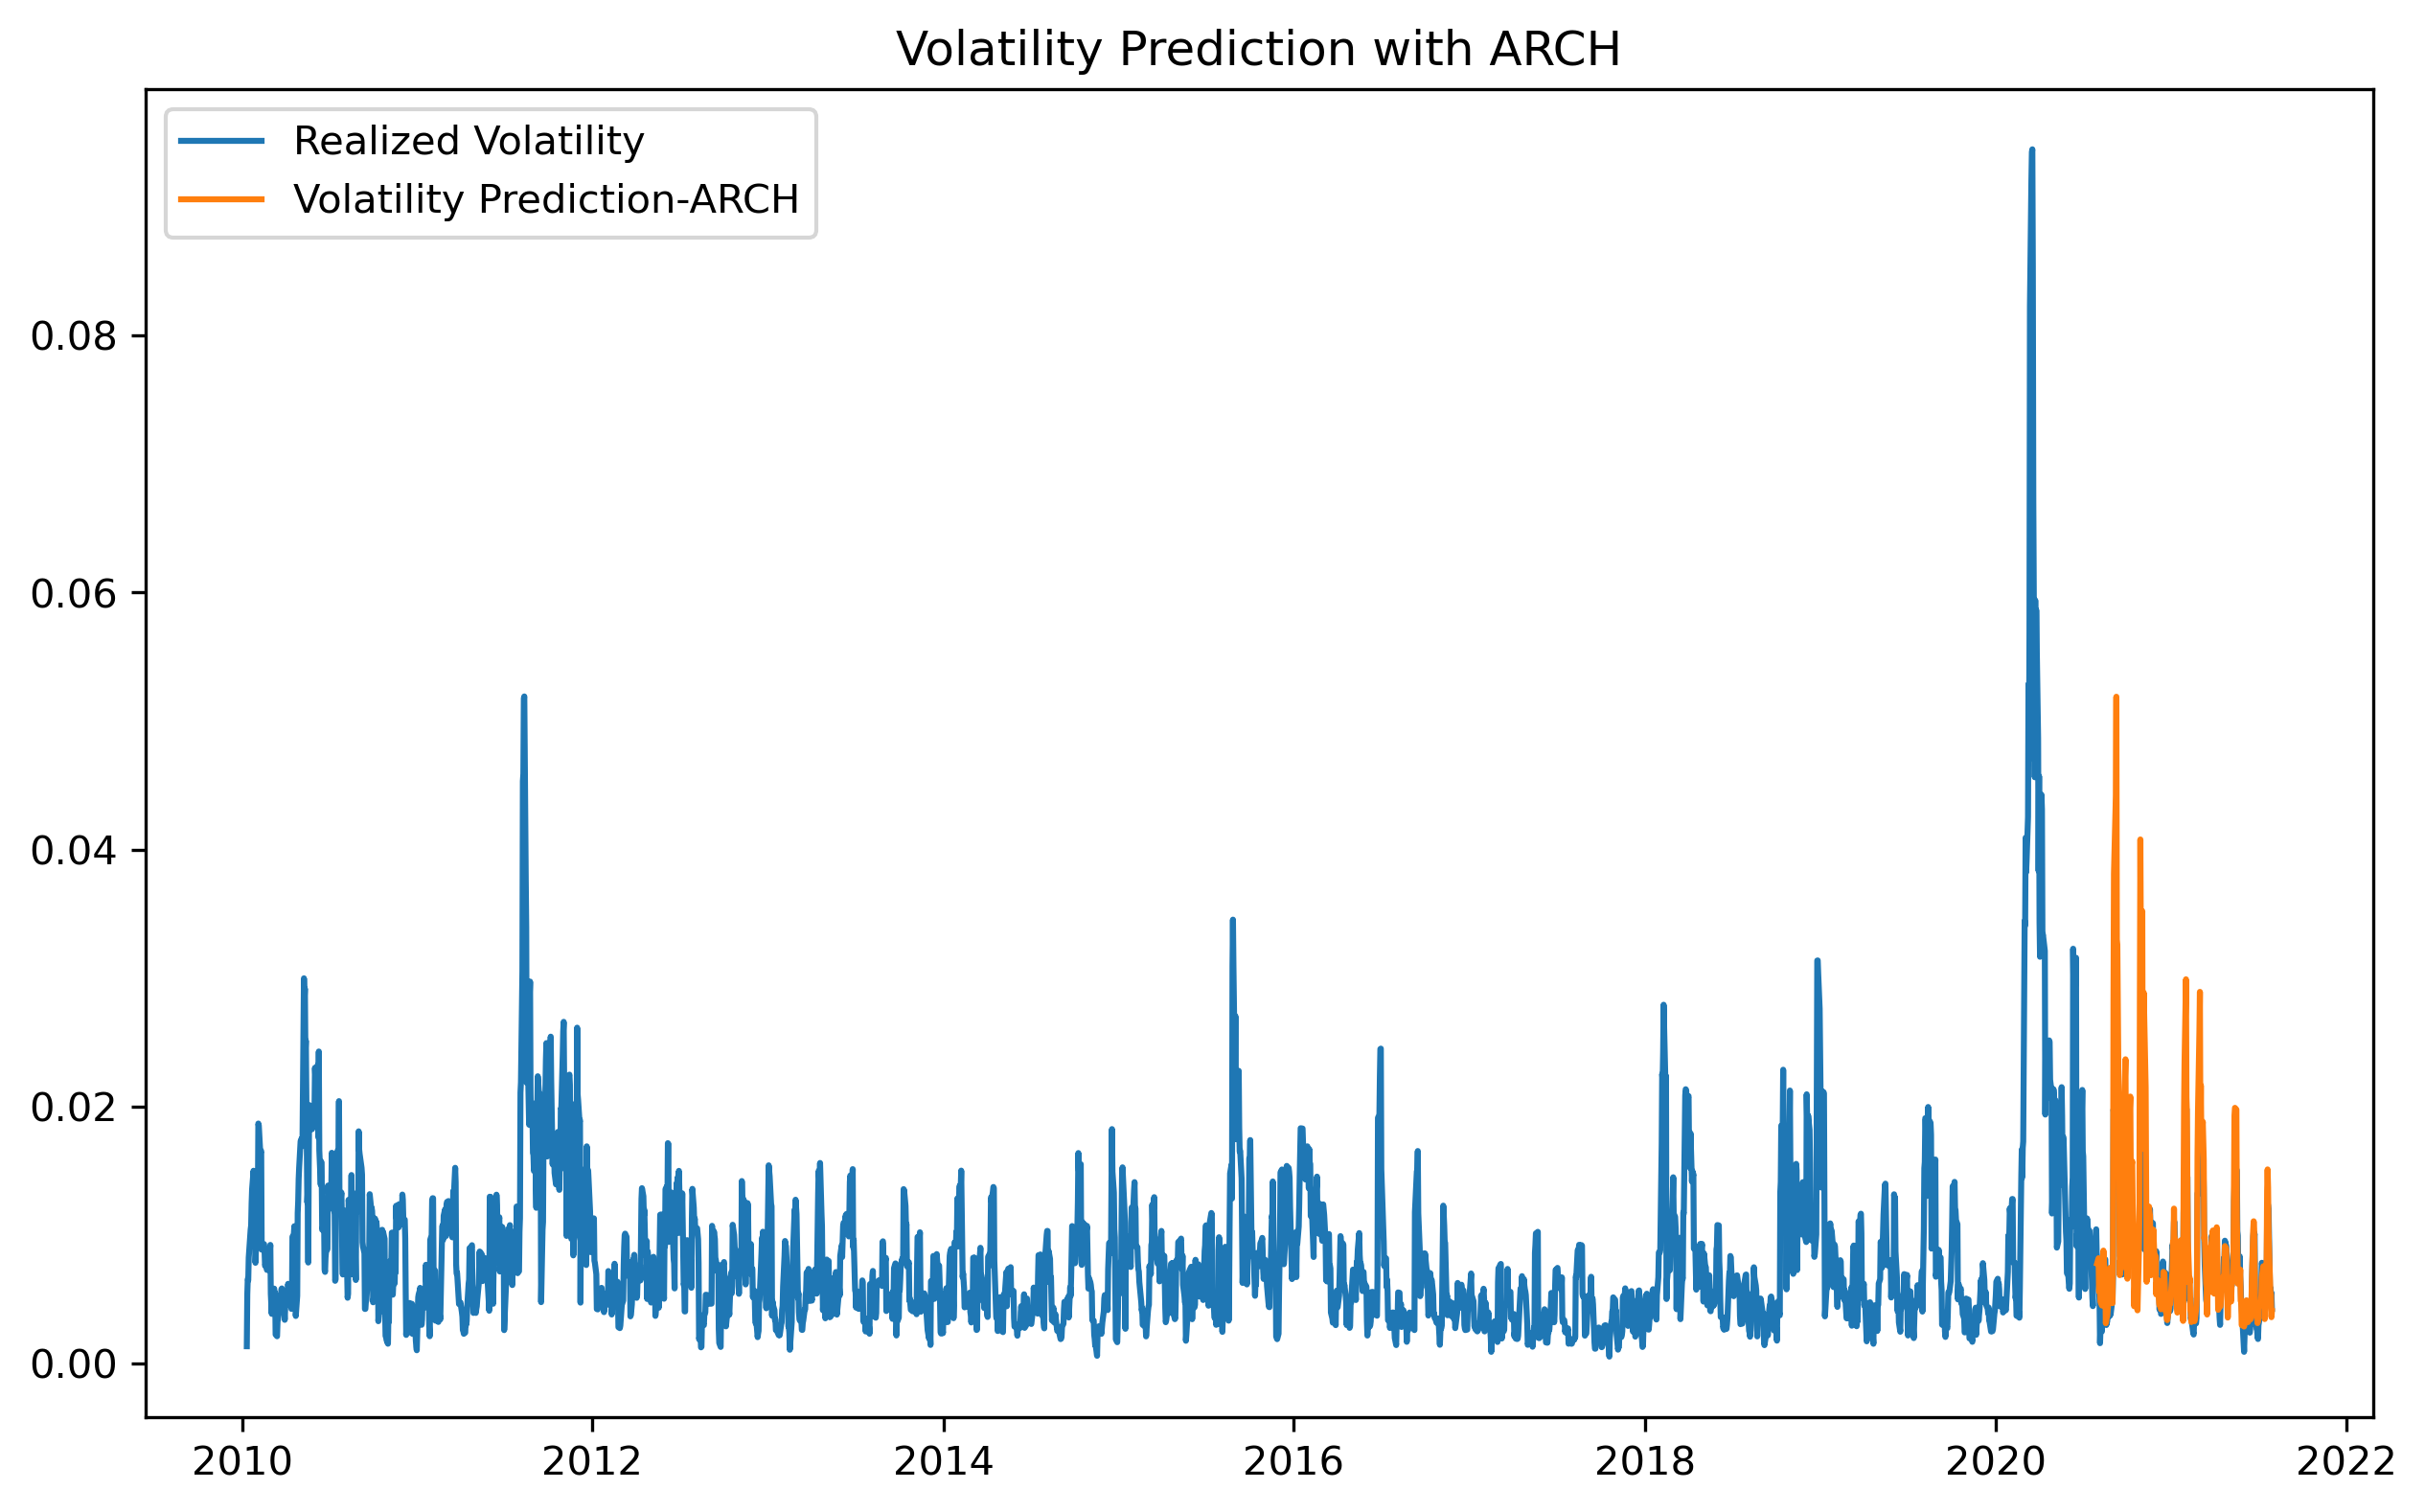

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

## GARCH

- GARCH는 지연 조선 분산을 통합한 ARCH 모델의 확장이다. 
- ARCH에 p개의 지연된 조건부 분산을 추가해 개선하면 다변량 GARCH 모델이 된다.
- 이는 p개의 지연 제곱 수익률과 q개의 지연 조건부 분산을 갖는 조건 분산의 자기 회귀 평균 모델이다.

- ARCH 모델은 과거 혁신적인 영향을 포착할 수 없다.
- GARCH 모델은 무한차 ARCH로 표현될 수 있기 때문에 좀 더 간결한 모델로서 역사적 혁신의 변화를 설명할 수 있다.

In [24]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1)\
        .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Fri, Dec 08 2023   Df Residuals:                     2913
Time:                        20:22:43   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

- 가장 낮은 BIC 값으로 최적의 매개변수 집합을 결정할 수 있다.

In [25]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Fri, Dec 08 2023   Df Residuals:                     2913
Time:                        20:22:44   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [26]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                         np.sqrt(forecast_garch\
                         .variance.iloc[-len(split_date):] 
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0878


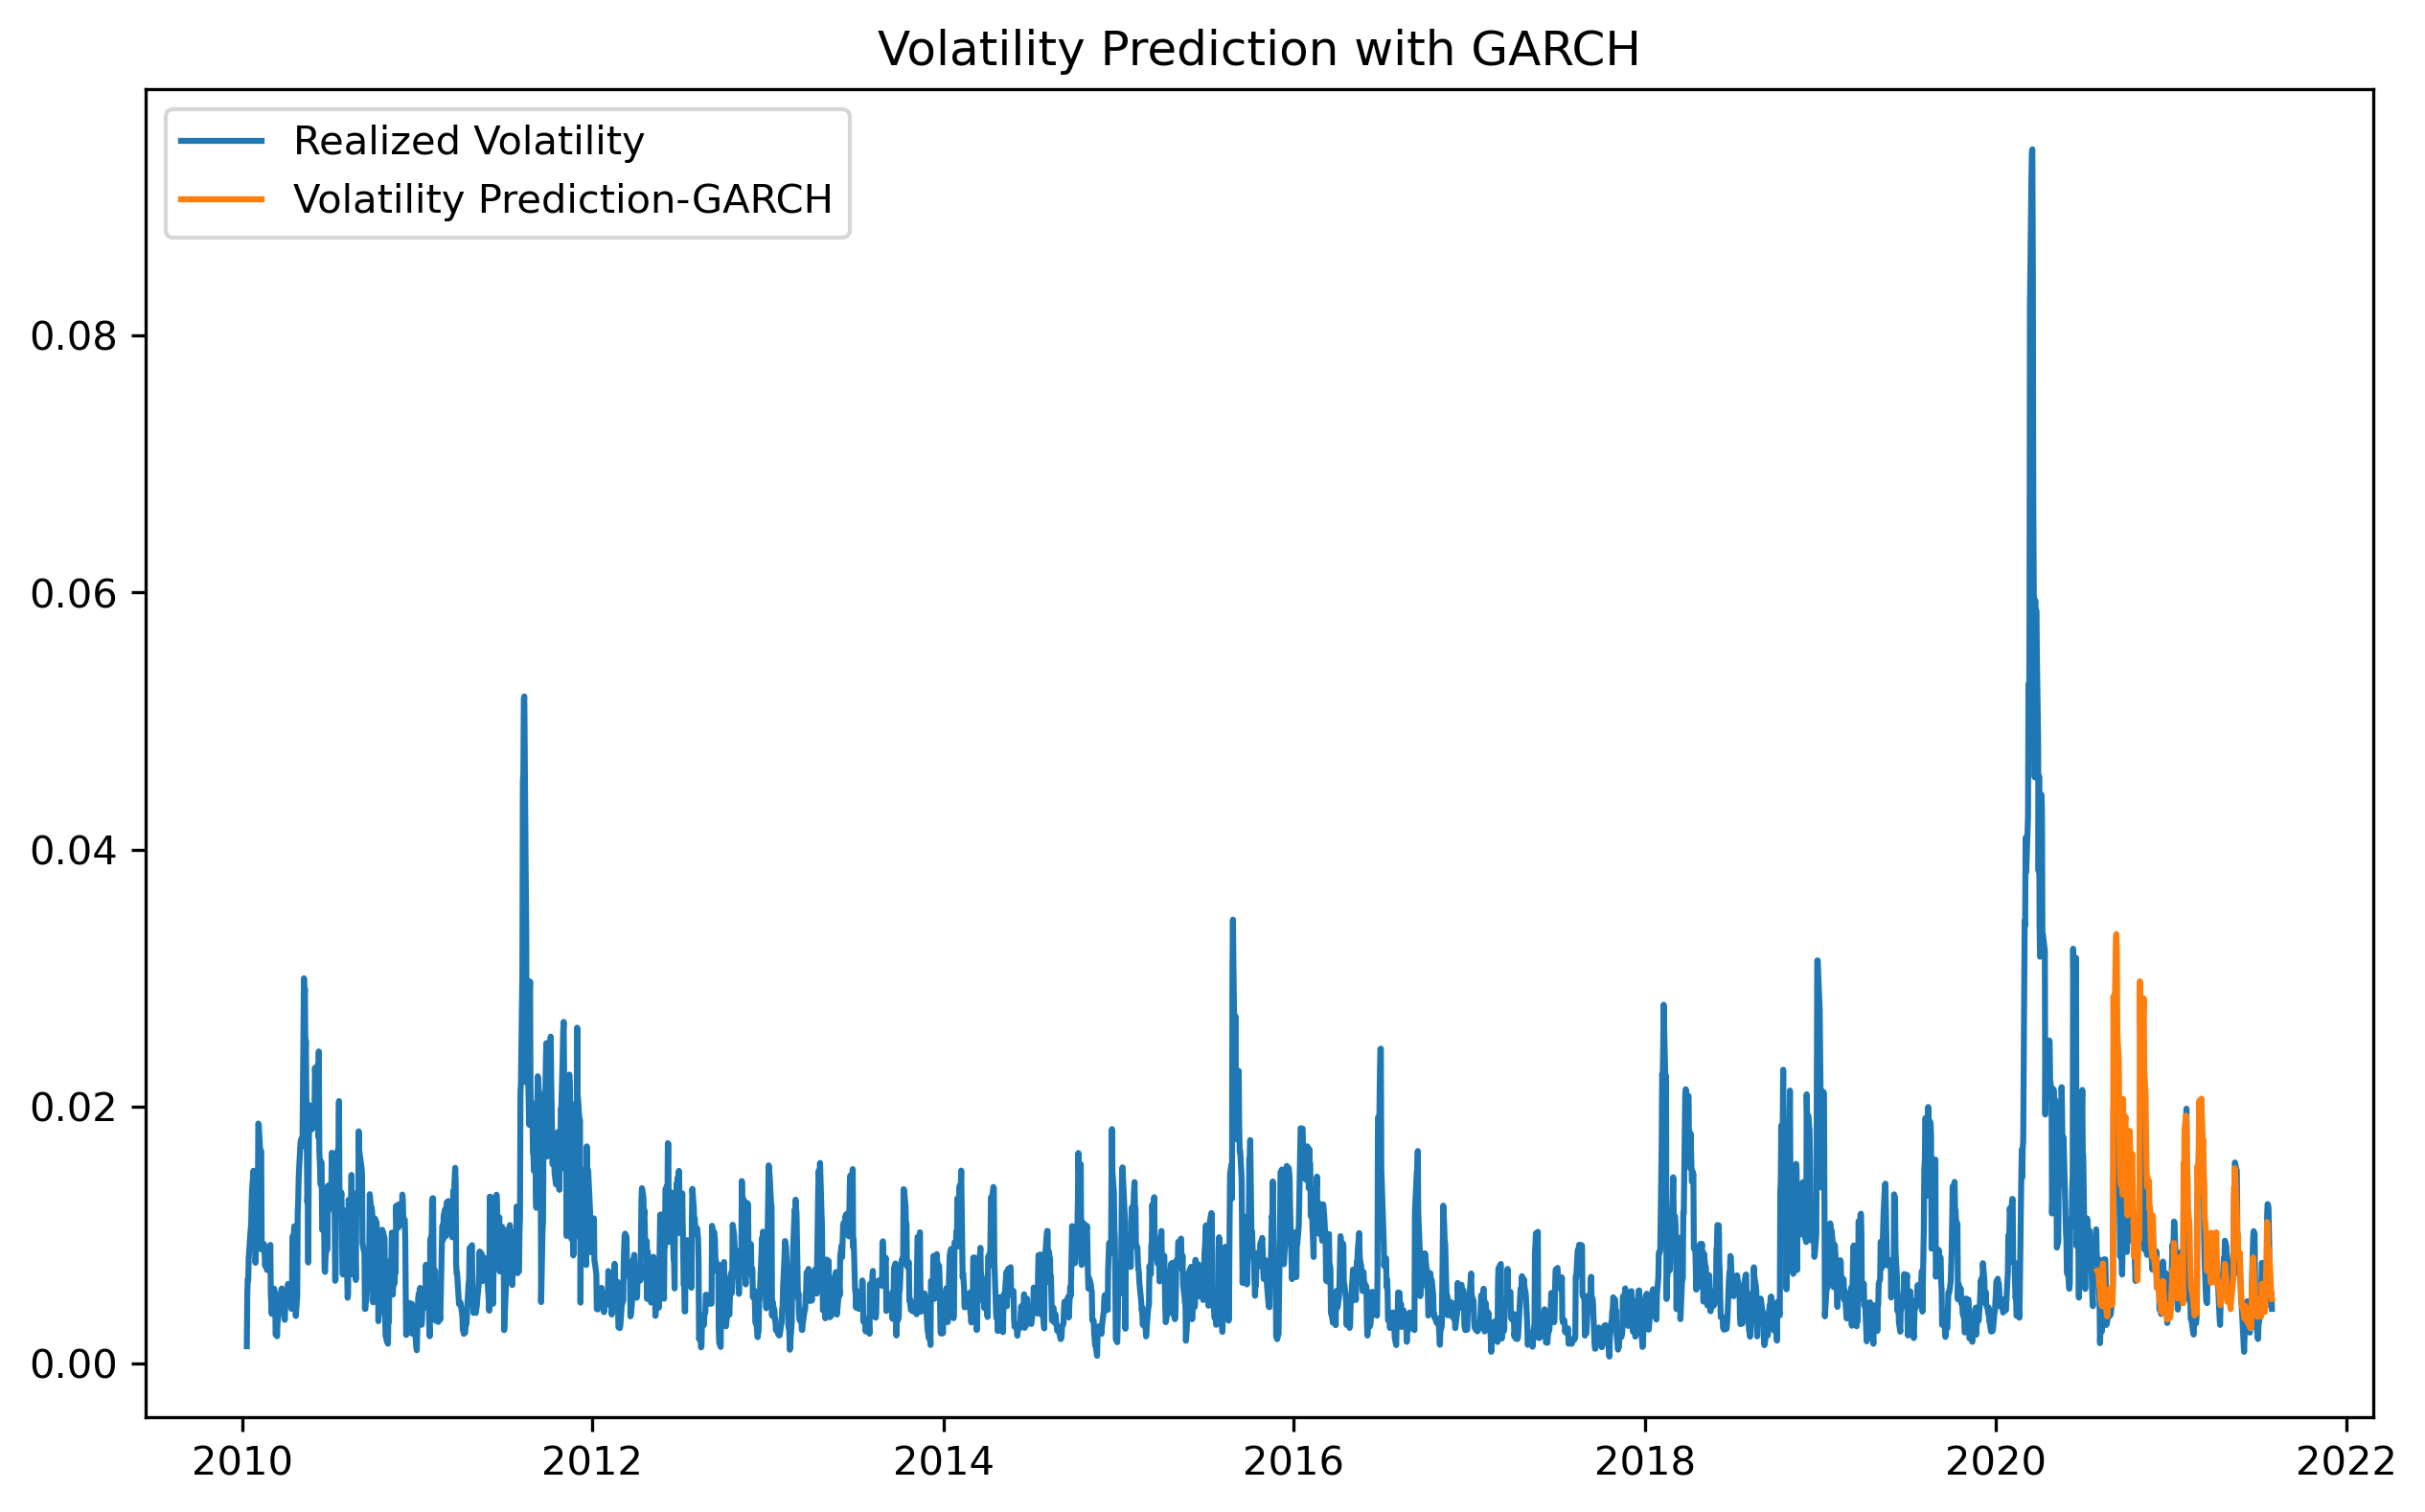

In [27]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

- 수익률 변동성은 GARCH 모델로 잘 적합화된다.
- 변동성 클러스터링과 부분적으로는 수익의 급첨(leptokurtic) 속성을 설명하기 위해 GARCH는 수익이 독립적이라고 가정하지 않기 때문이다.
- 그러나 이런 직관성에도 불구하고 GARCH는 충격의 비대칭 반응을 모델링 할 수 없다.

## GJR-GARCH

- 나쁜 소식이 좋은 소식보다 더 큰 영향을 미치는 방식으로 발표의 비대칭 효과를 잘 모델링한다.
- 비대칭이 있는 경우 손실의 분포가 이익의 분포보다 꼬리가 두꺼워진다.

In [28]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q)\
                   .fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1,
                      q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3591.15
Distribution:                  Normal   AIC:                           7190.30
Method:            Maximum Likelihood   BIC:                           7214.21
                                        No. Observations:                 2913
Date:                Fri, Dec 08 2023   Df Residuals:                     2913
Time:                        20:22:47   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0430  7.754e-03      5.547  2.908e-08 

In [29]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                             np.sqrt(forecast_gjrgarch\
                             .variance.iloc[-len(split_date):]
                             / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'
      .format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.0882


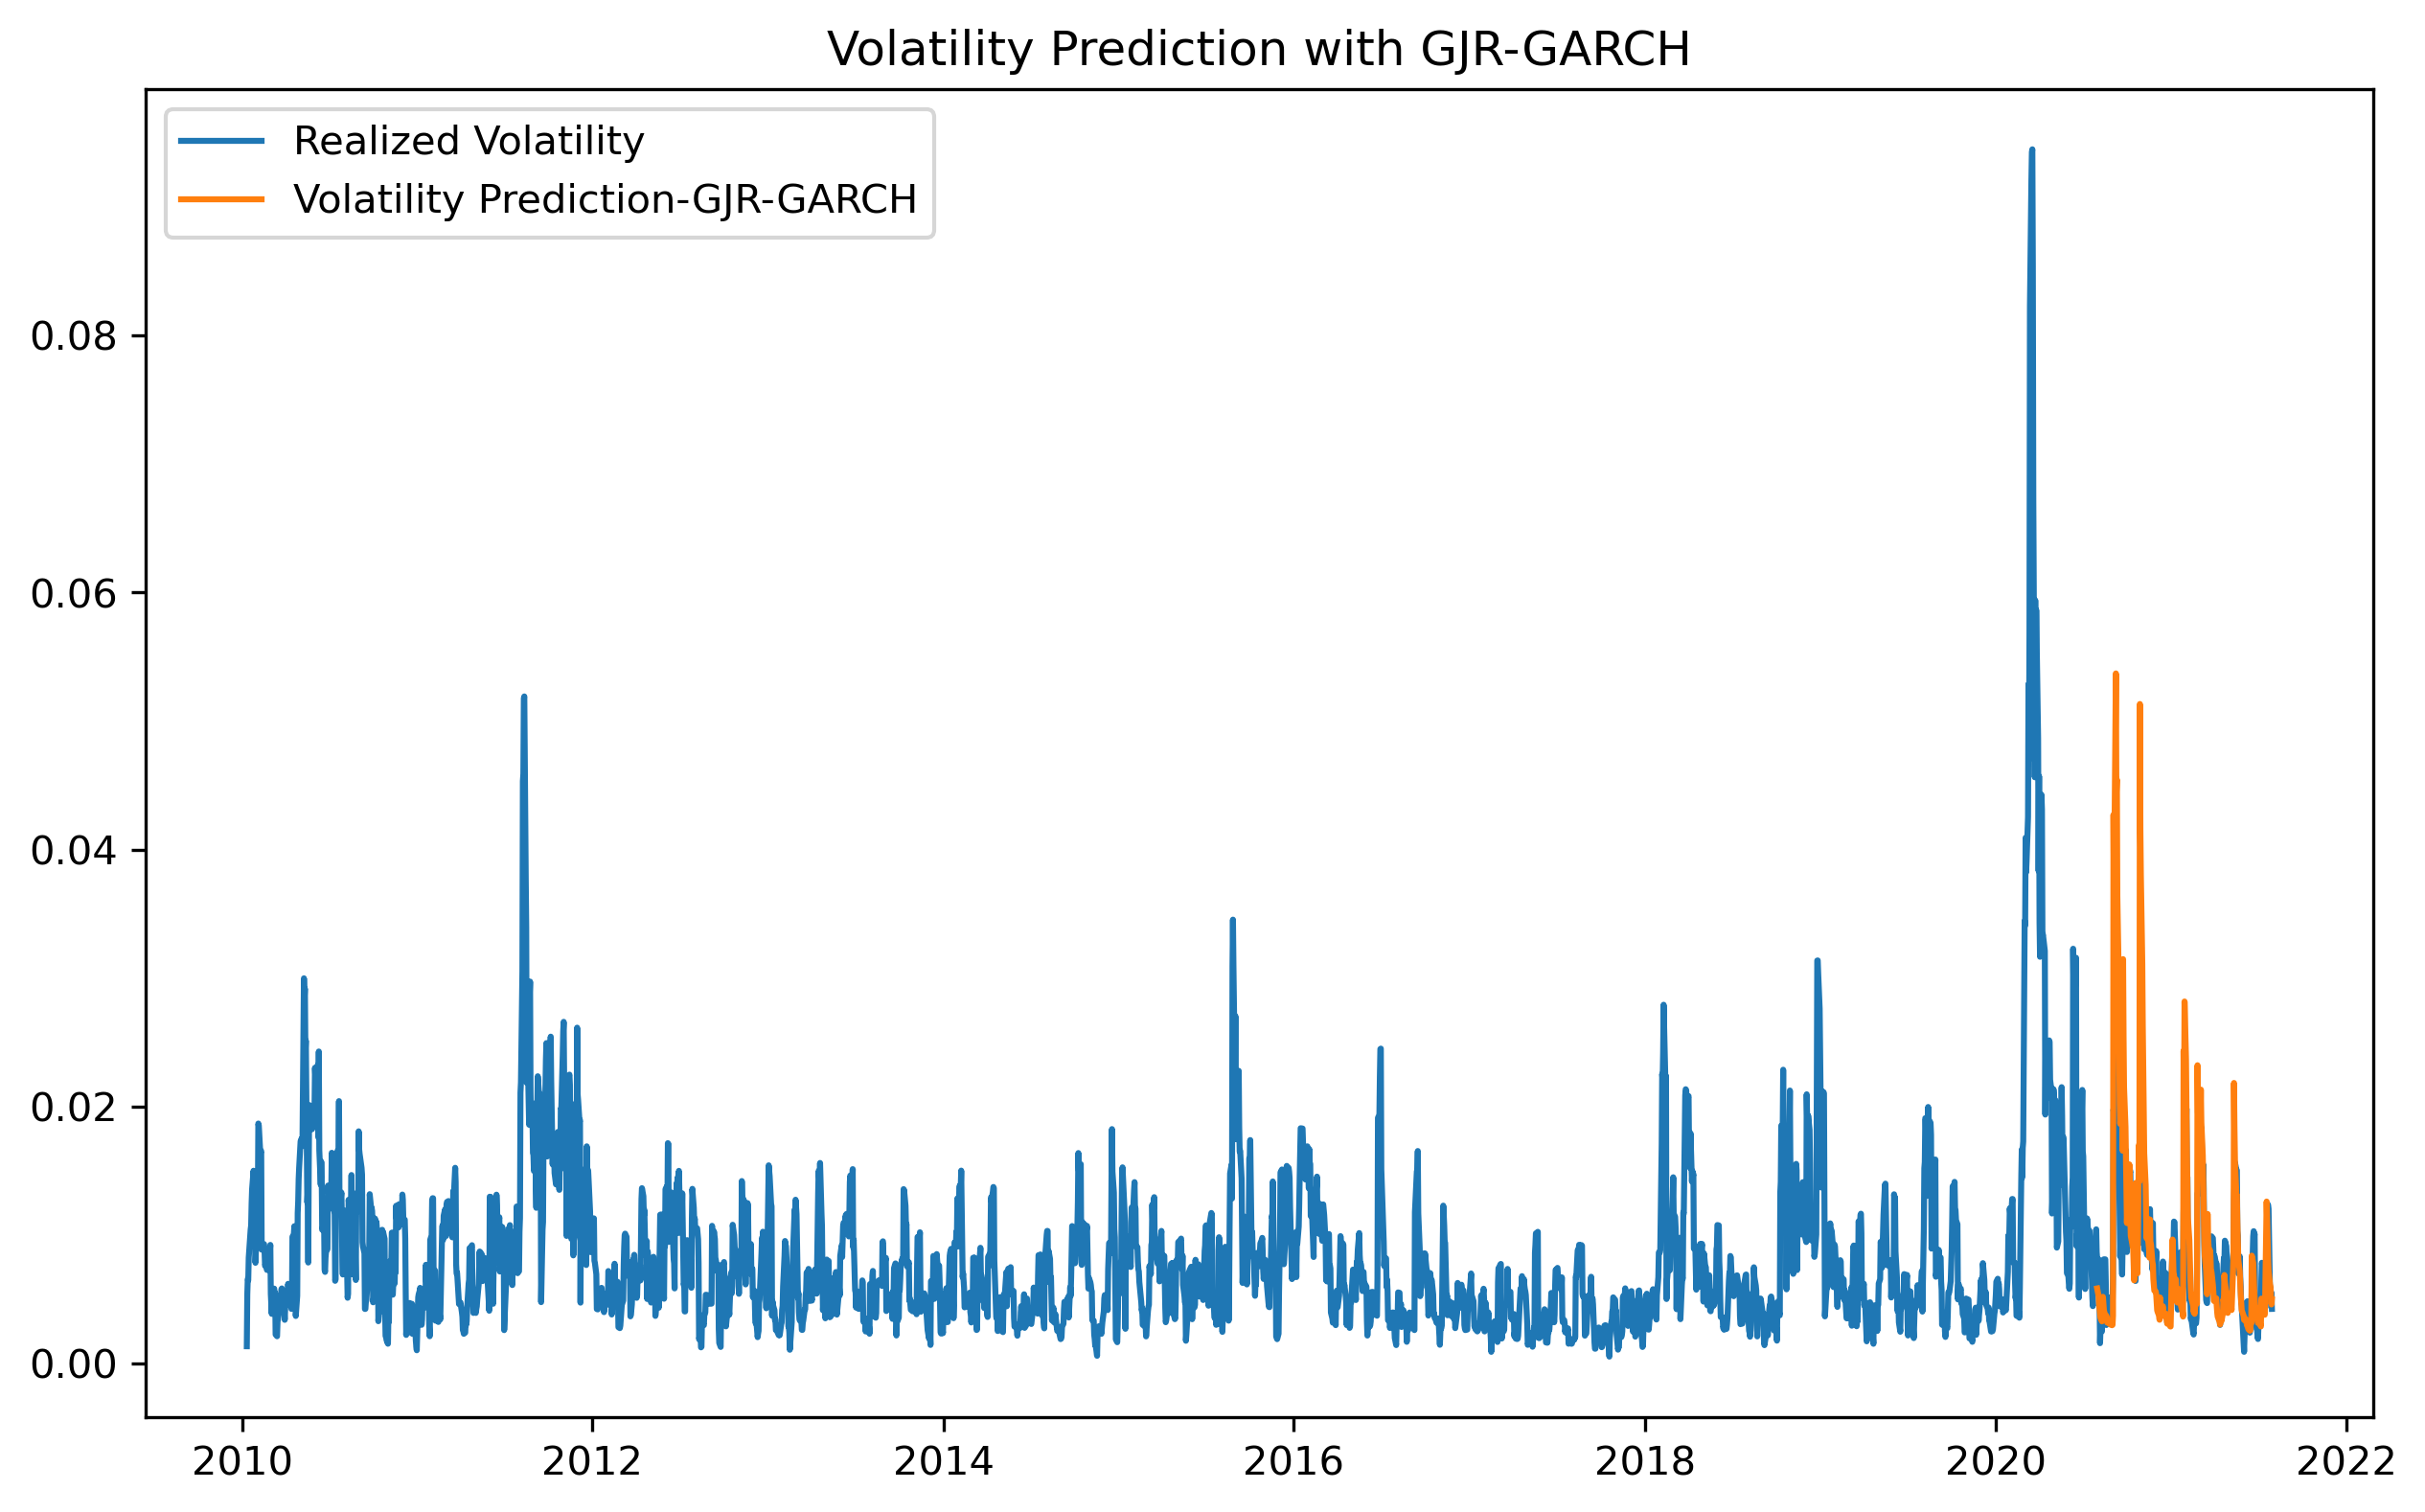

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

## EGARCH

- GJR-GARCH 모델과 함께 비대칭 공지의 효과를 제어하기 위한 도구 이다.
- 로그 형식으로 지정되므로 음의 변동성을 피하기 위한 추가적 제약이 필요 없다.

In [31]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q)\
                 .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
         .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3673.53
Distribution:                  Normal   AIC:                           7353.05
Method:            Maximum Likelihood   BIC:                           7370.98
                                        No. Observations:                 2913
Date:                Fri, Dec 08 2023   Df Residuals:                     2913
Time:                        20:22:48   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.4573e-03  6.769e-03      0.363      0.717 

In [32]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100,
                          np.sqrt(forecast_egarch.variance\
                          .iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.0904


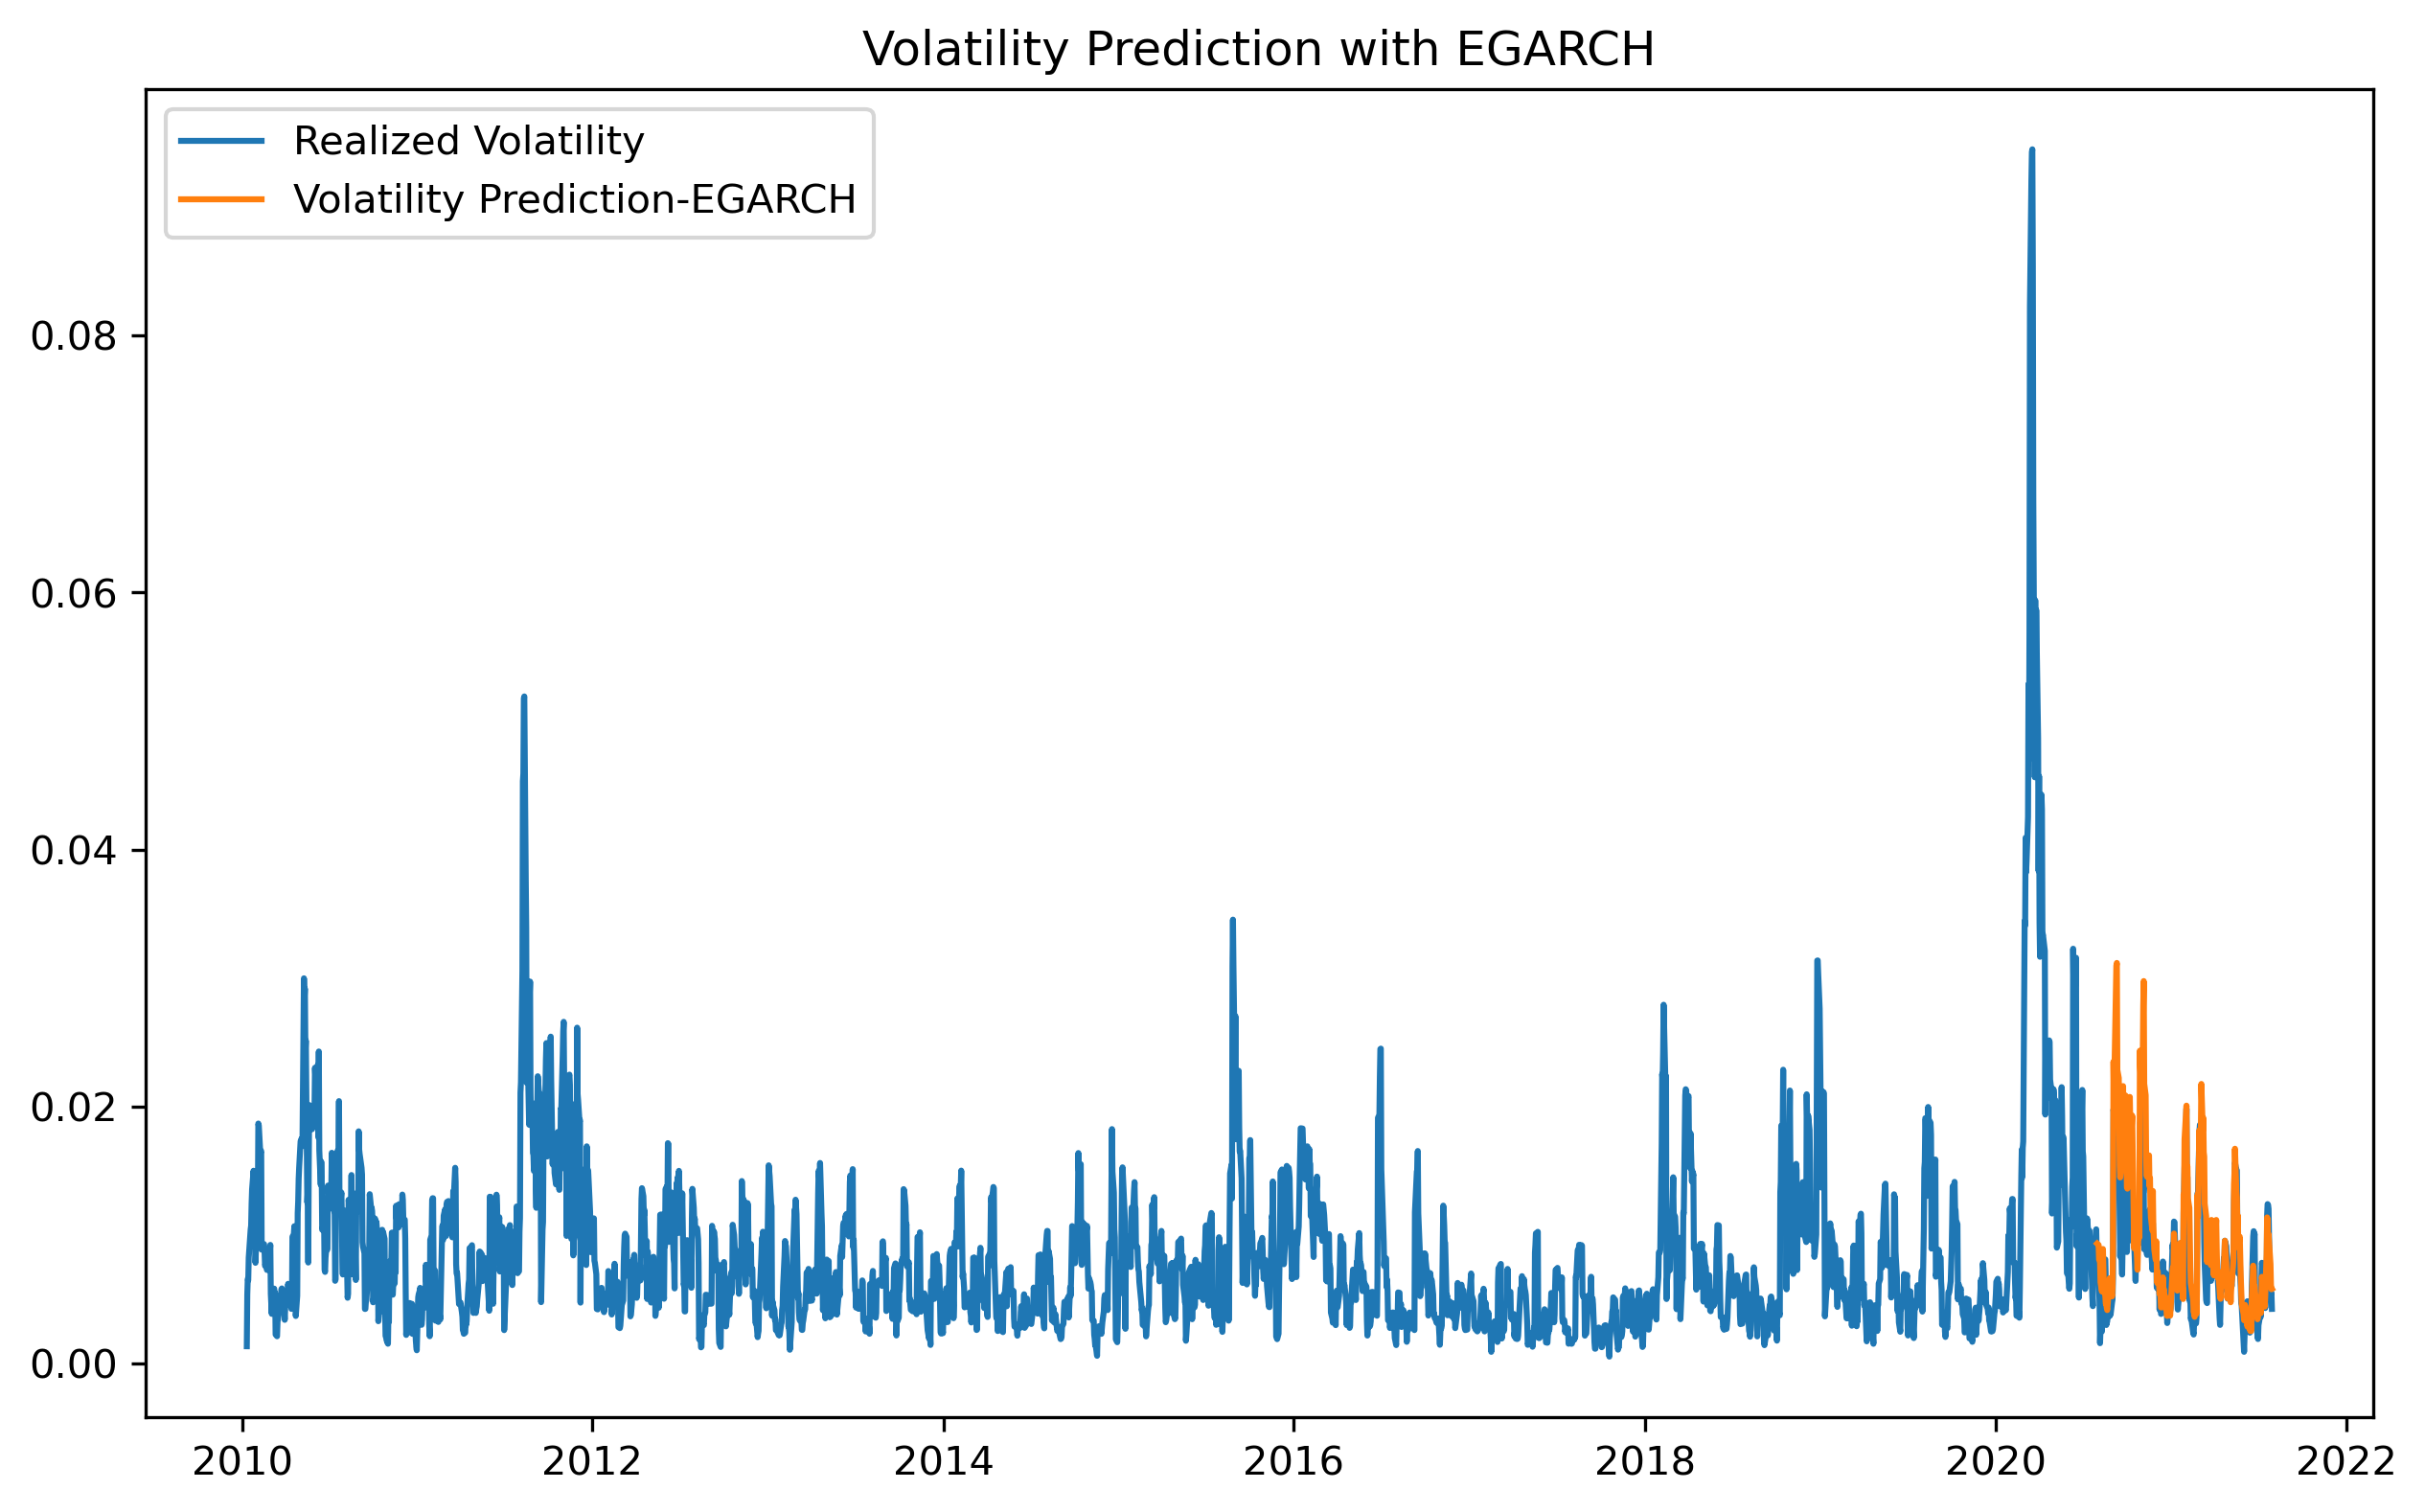

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

### SVM

- SVM은 분류와 회귀 모두에 적용할 수 있는 지도 학습
- SVM의 목적은 두 그룹을 구분하는 선을 찾는 것이다.
- 하지만 구분하는 데 사용할 수 있는 선은 거의 무한 개이다.

## SVR-GARCH

- SVM 회귀는 모든 특성을 유지하면서 회귀에 적용할 수도 있다.
- 이 회귀의 목표는 오차를 최소화하고 마진을 최대화 하는 초평면을 찾는 것이다.
- SVR을 GARCH모델에 적용하면 SVRGARCH가 된다.

- 실현 변동성과 과거 수익률의 제곱인 독립변수를 얻는 것이 가장 중요하다.

In [34]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [35]:
realized_vol = ret.rolling(5).std() #실현 변동성을 계산하고 realized_vol 이라는 새 변수를 할당 한다.
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [36]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

In [37]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [38]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [39]:
svr_poly = SVR(kernel='poly', degree=2) #각 SVR 커널에 대한 새로운 변수 생성
svr_lin = SVR(kernel='linear') #각 SVR 커널에 대한 새로운 변수 생성
svr_rbf = SVR(kernel='rbf') #각 SVR 커널에 대한 새로운 변수 생성

### SVR-GARCH-Linear

In [40]:
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()} # 튜닝을 위한 초매개변수 공간 식별
clf = RandomizedSearchCV(svr_lin, para_grid)  #RandomizedSearchCV로 초매개변수 튜닝 적용
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))  # 선형 커널로 SVR-GRACH를 데이터 적합화
predict_svr_lin = clf.predict(X.iloc[-n:]) #지난 252개의 관측치를 기반으로 변동성을 예측하고 이를 predict_svr_lin에 저

In [41]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [42]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                       predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
      .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.000473


In [43]:
realized_vol.index = ret.iloc[4:].index

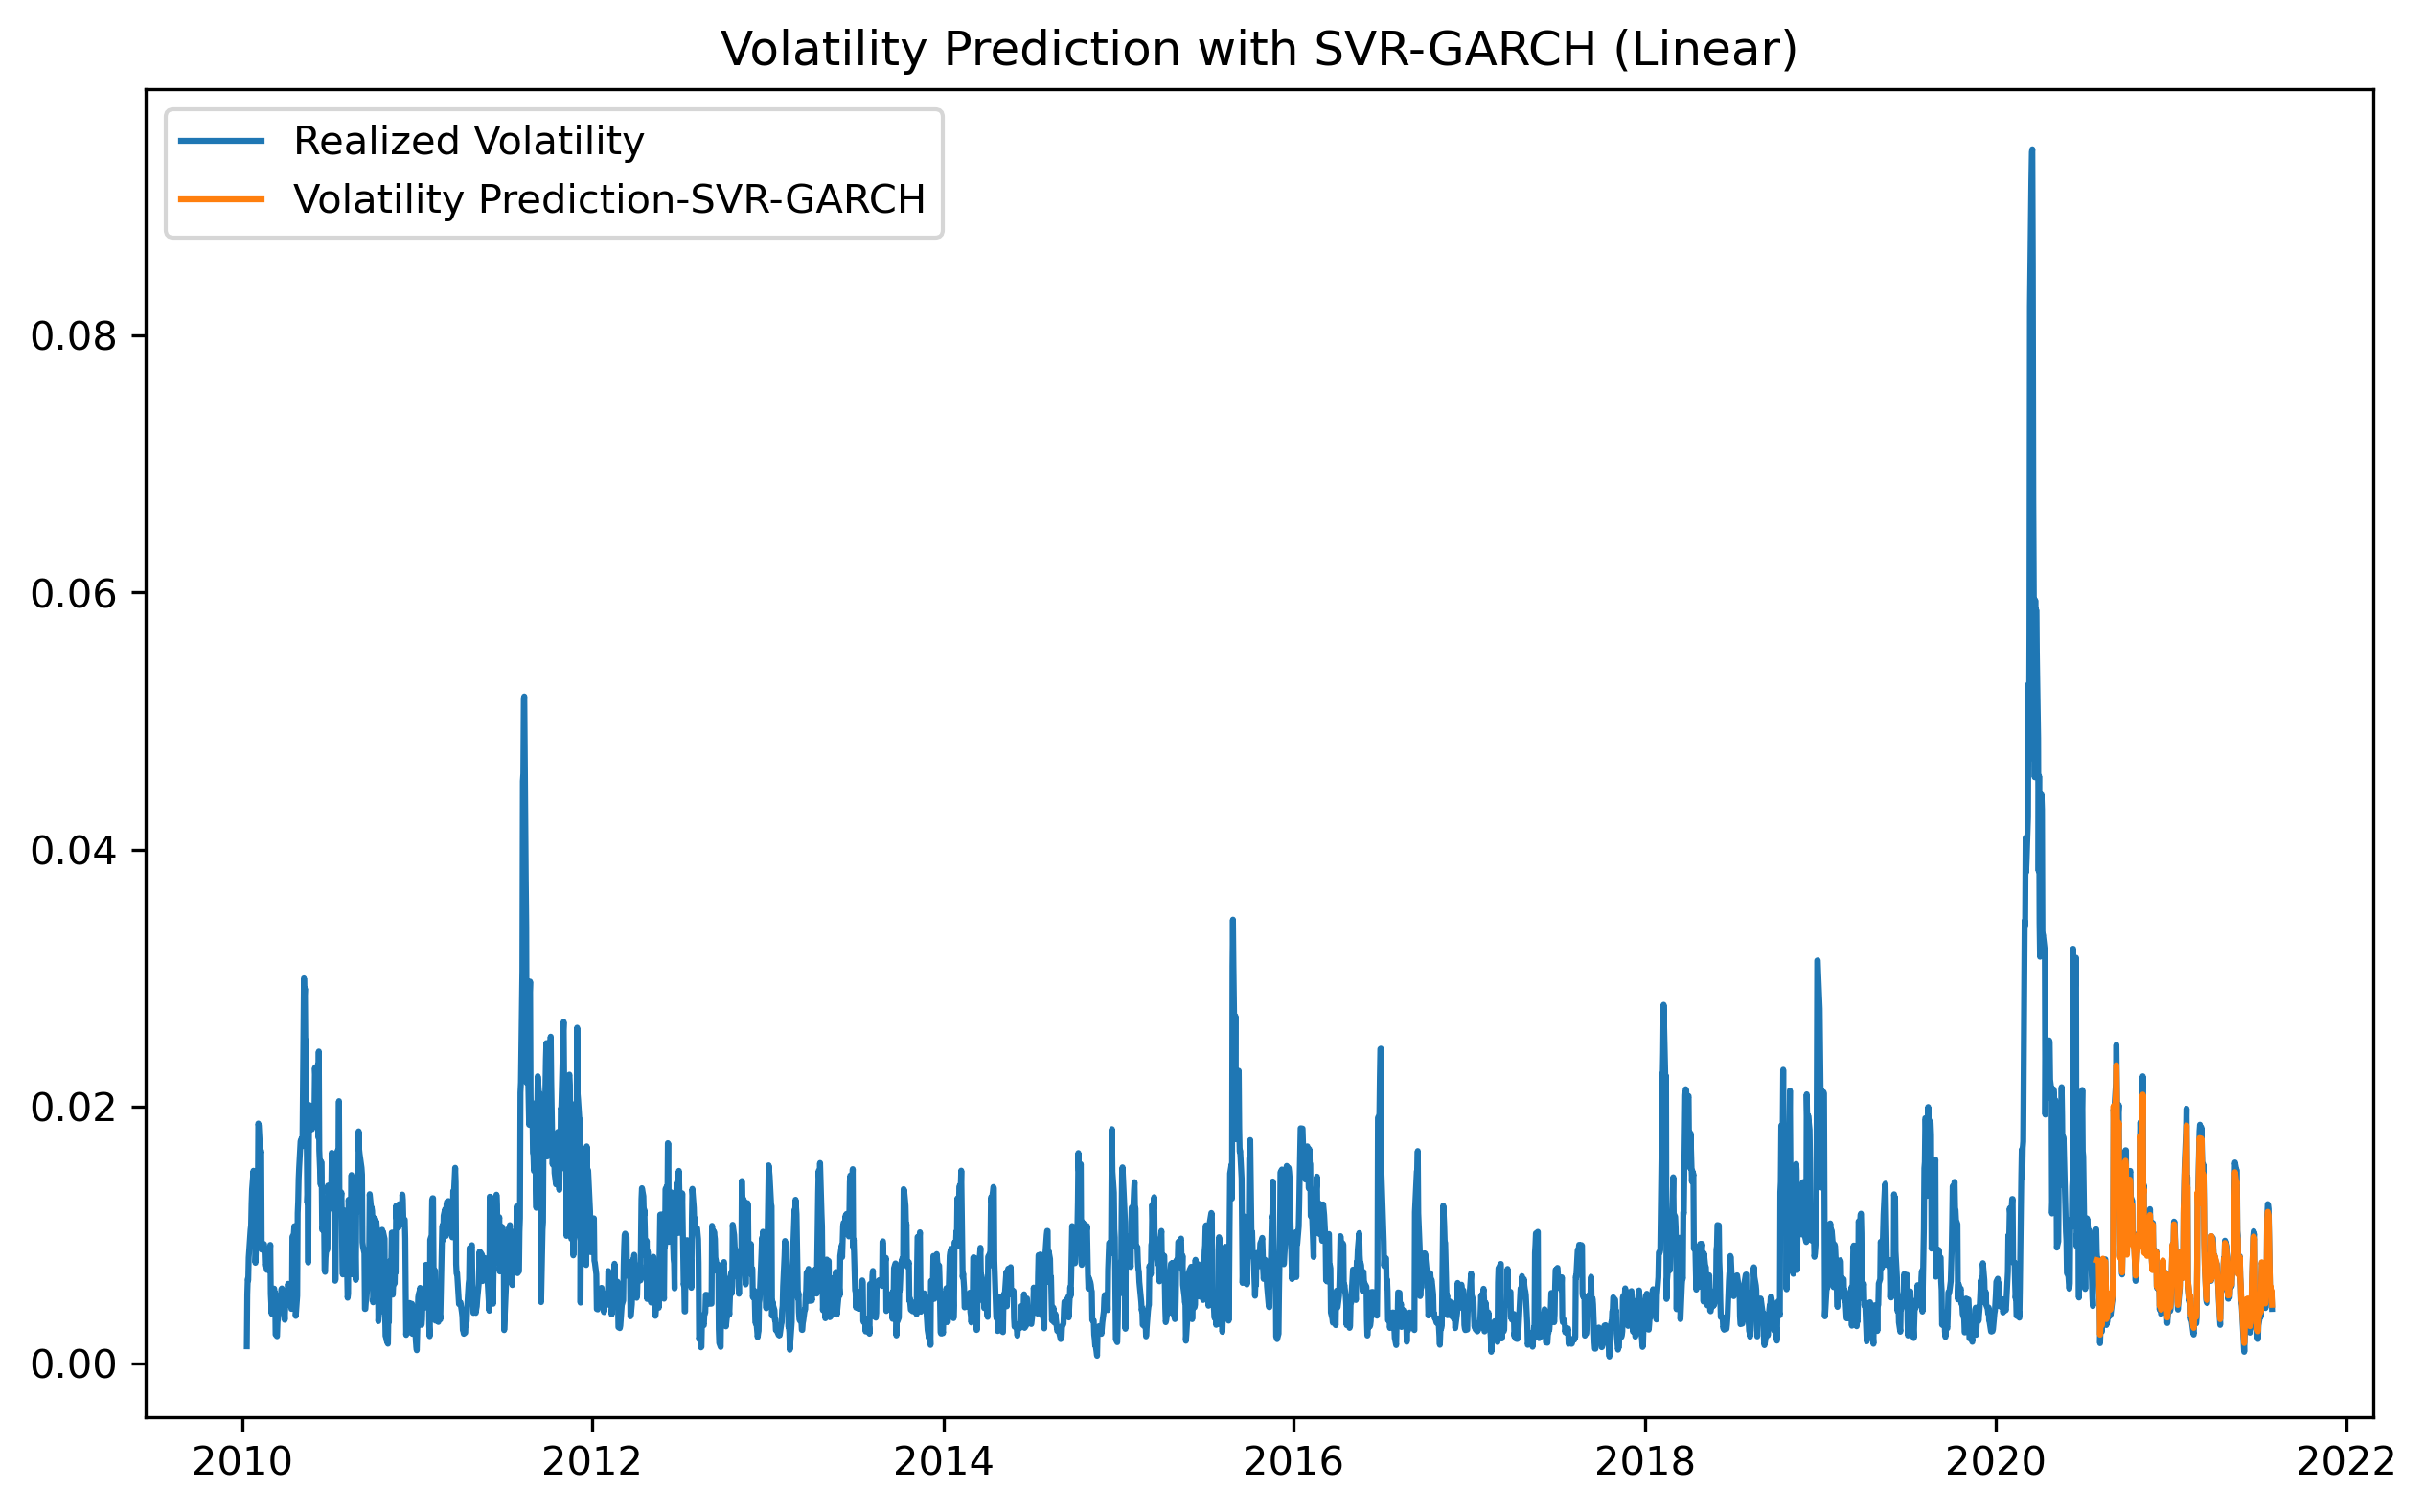

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH RBF

- 데이터셋을 선형으로 분리할 수 없을 때, 커널 함수를 사용한다.

In [45]:
para_grid ={'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [46]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [47]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                           predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
      .format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.000759


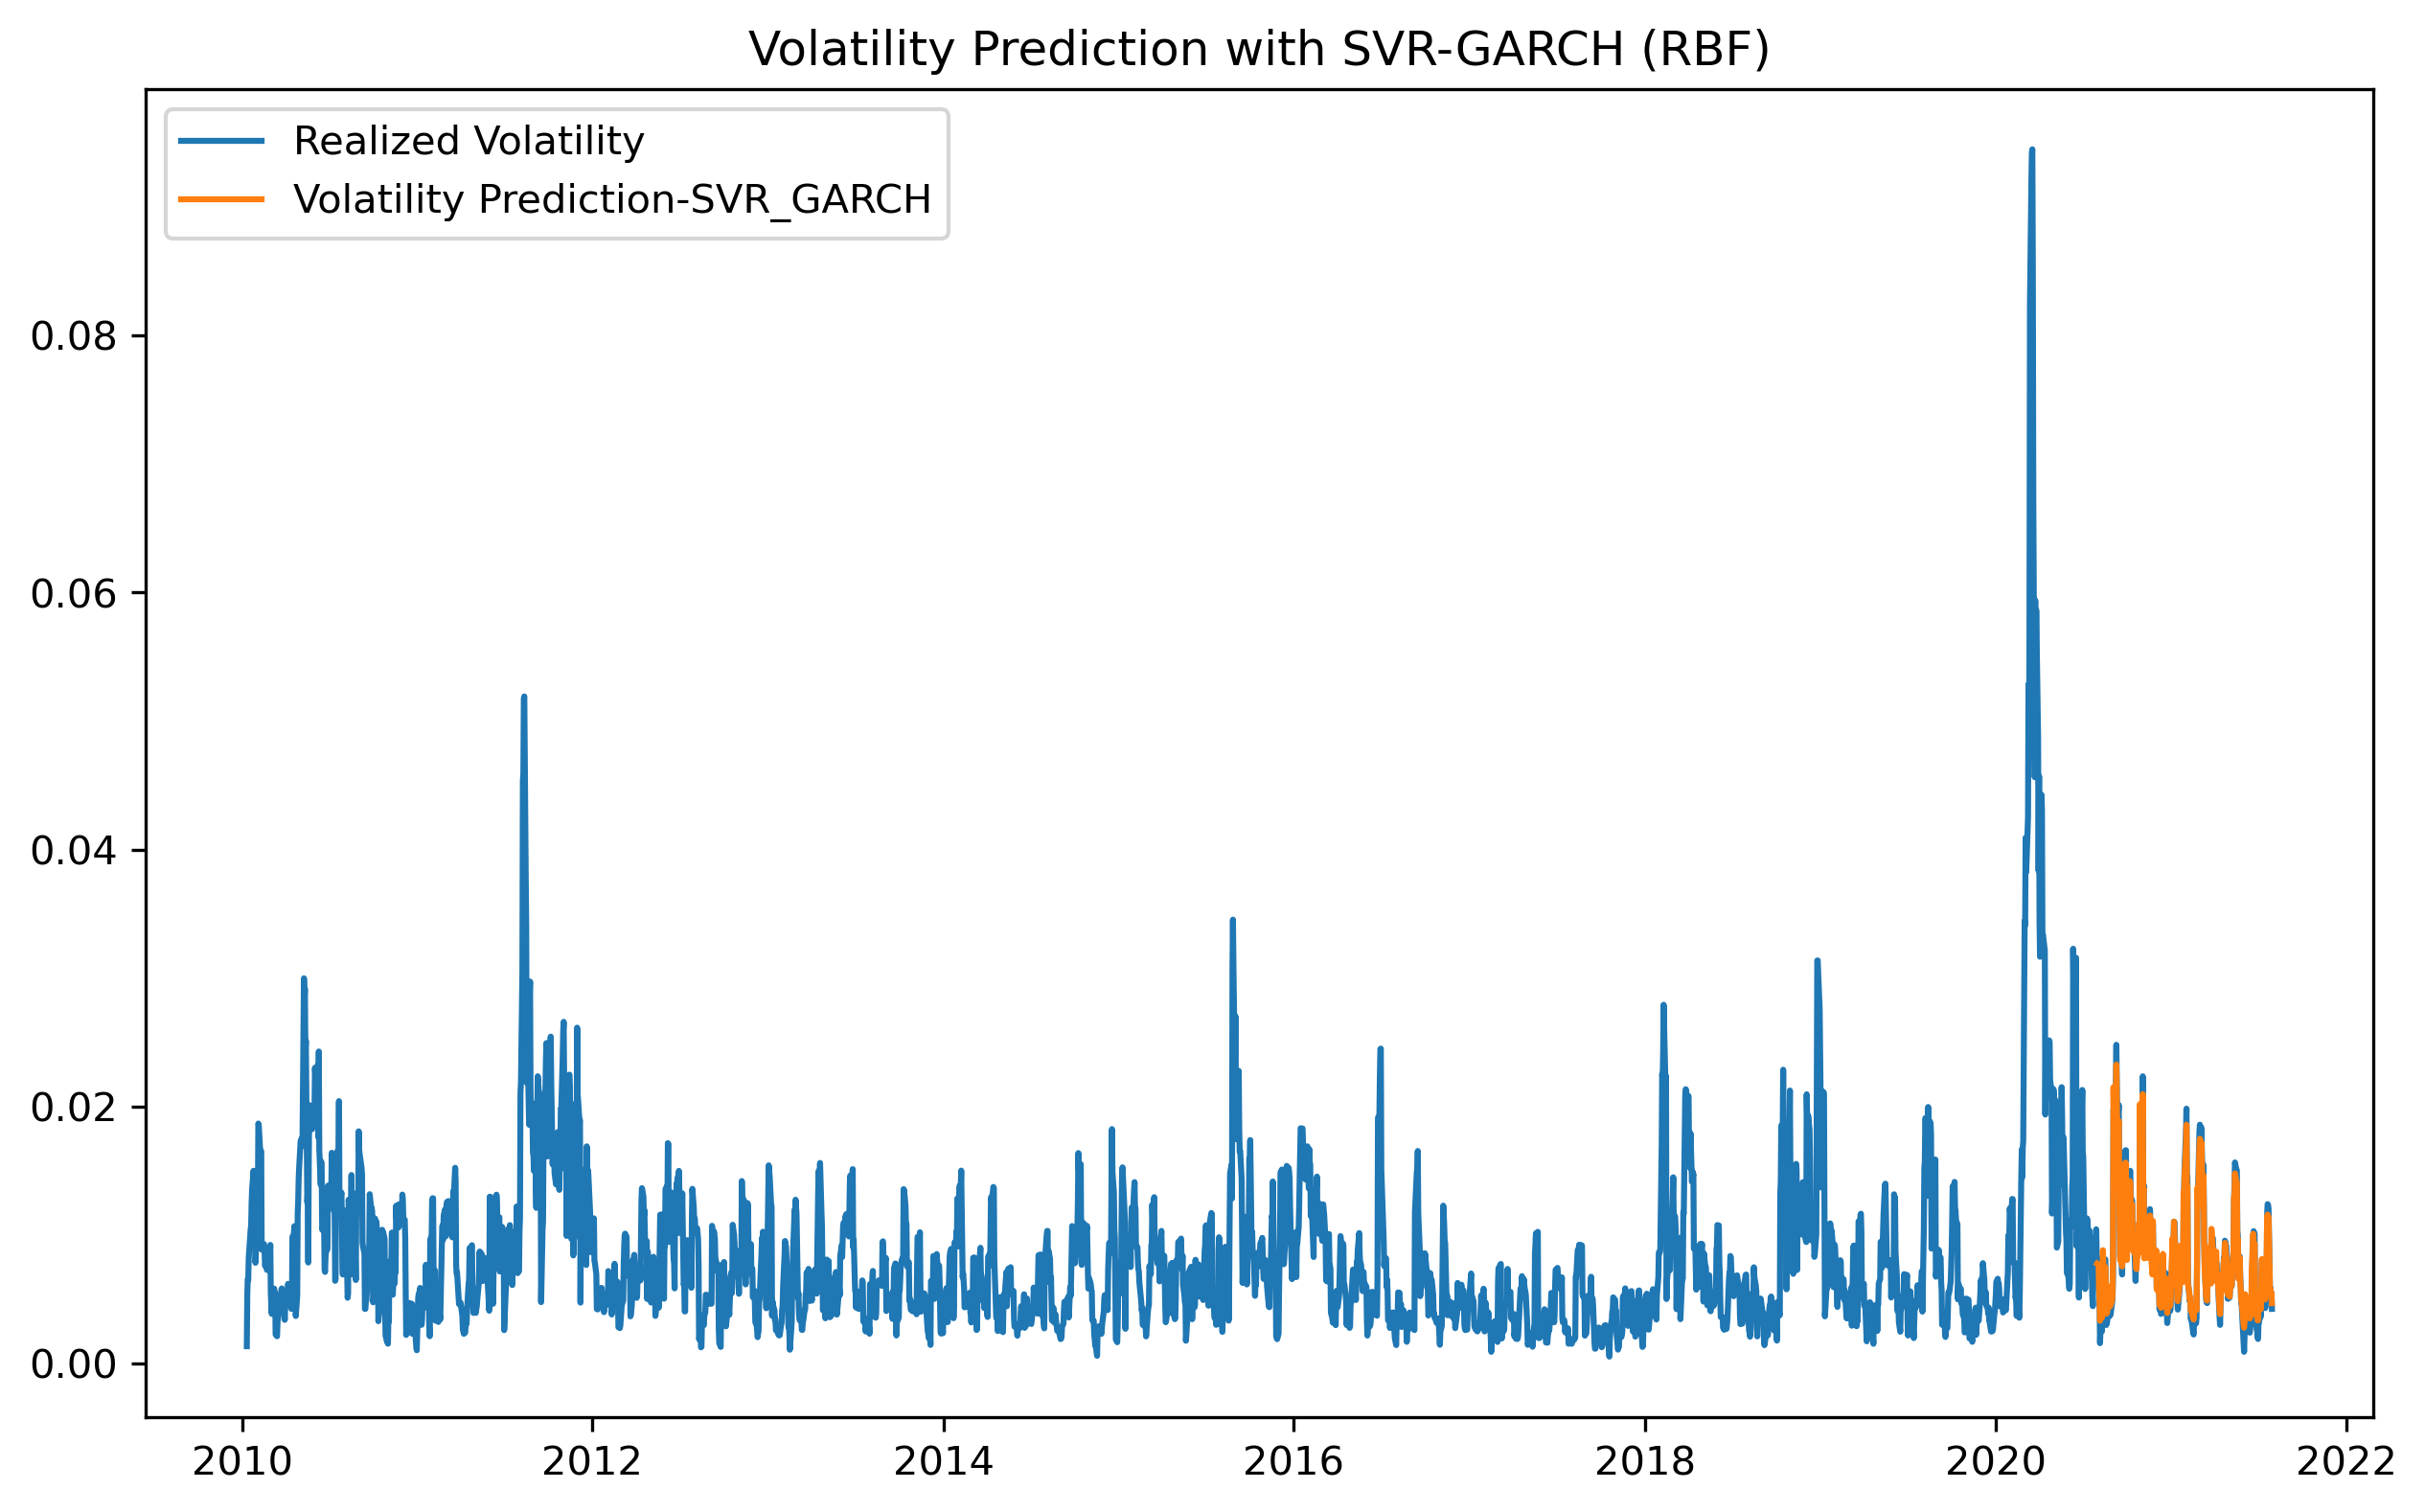

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH Polynomial

In [ ]:
para_grid = {'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

In [ ]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

In [ ]:
rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'\
      .format(rmse_svr_poly))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)',
          fontsize=12)
plt.legend()
plt.show()

## NN-GARCH

- 신경망을 기반으로 한 변동성 예측 결과

In [ ]:
from sklearn.neural_network import MLPRegressor #MLPRegressor 모듈
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1) 
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
               'max_iter': [500, 1000],
               'alpha': [0.00005, 0.0005 ]} #3개의 은닉층과 다양한 뉴런 개수로 신경망 모델 구성
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1, )) #훈련 데이터에 신경망 모델 적합화
NN_predictions = clf.predict(X.iloc[-n:]) #마지막 252개의 관측치를 기반으로 변동성을 예측하고 NN_predictions 변수에 저장

In [ ]:
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

In [ ]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                      NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

## DL-GARCH // 딥러닝 GARCH

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential(
    [layers.Dense(256, activation="relu"),
     layers.Dense(128, activation="relu"),
     layers.Dense(1, activation="linear"),])  #계층과 뉴런의 수를 결정해 네트워크 구조 구성

In [ ]:
model.compile(loss='mse', optimizer='rmsprop')  #손실 및 최적화 프로그램을 사용해 모델 컴파일

In [ ]:
epochs_trial = np.arange(100, 400, 4)  #np.arange를 사용해 에폭(Epoch)과 배치 크기 결정
batch_trial = np.arange(100, 400, 4) #np.arange를 사용해 에폭(Epoch)과 배치 크기 결정
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)  #딥러닝 모델 적합화
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))  #훈련 단계에서 얻은 가중치를 기반으로 변동성 예측
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            DL_predict.flatten() / 100)))  #예측을 평탄화해 RMSE 점수 계산
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

In [ ]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

- 에폭과 배치 크기가 100일 때 최소 RMSE 점수를 얻을 수도 있다. 
- 이것은 모델의 복잡성이 증가한다고 해서 반드시 높은 예측 성능을 의미하는 것은 아님을 보여준다.
- 핵심을 복잡도와 예측 성능 사이에서 최적의 지점을 찾는 것이다.

## Bayesian Approach

- 베이즈 접근 방식은 조건부 분포를 기반으로 하며, 확률은 불확실한 이벤트에 대한 정도를 측정한다. 
- 따라서 베이즈 응용은 새로운 정보에 비춰 보유하고 있는 신념을 갱신하는 데 사용할 수 있는 규칙을 제안한다.

#### 마크코프 체인 몬테 카를로
- 마르코프 체인은 상태 사이의 전환 확률을 설명하는 데 사용되는 모델이다. 
- MCMC 방법은 사후 확률을 계산할 수 있도록 사후 밀도에서 IID 샘플을 수집하게 해준다.

In [ ]:
import quantecon as qe
from quantecon import MarkovChain
import networkx as nx
from pprint import pprint 

In [ ]:
P = [[0.5, 0.2, 0.3],
     [0.2, 0.3, 0.5],
     [0.2, 0.2, 0.6]]

mc = qe.MarkovChain(P, ('studying', 'travelling', 'sleeping'))
mc.is_irreducible

In [ ]:
states = ['studying', 'travelling', 'sleeping']
initial_probs = [0.5, 0.3, 0.6]
state_space = pd.Series(initial_probs, index=states, name='states')

In [ ]:
q_df = pd.DataFrame(columns=states, index=states)
q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.5, 0.2, 0.3]
q_df.loc[states[1]] = [0.2, 0.3, 0.5]
q_df.loc[states[2]] = [0.2, 0.2, 0.6]

In [ ]:
def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges
edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

In [ ]:
G = nx.MultiDiGraph()
G.add_nodes_from(states)
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)
edge_labels = {(n1, n2):d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'mc_states.dot')

## 메트로폴리스-헤이스팅스 접근

- MH를 사용하면 샘플링 절차를 두 단계로 효율적으로 수행할 수 있다.
- 먼저 제시된 밀도에서 샘플을 추출한 다음 수락 혹은 기각을 결정한다.


In [ ]:
import pyflux as pf  #베이즈 정리를 사용하기 위한 라이브러리
from scipy.stats import kurtosis

In [ ]:
model = pf.GARCH(ret.values, p=1, q=1) #pyflux 라이브러리를 사용해 GARCH 모델 구성
print(model.latent_variables) #잠재 변수(매개변수)의 추정값 출력
model.adjust_prior(1, pf.Normal()) #모델 잠재변수에 대한 사전 분포 조정
model.adjust_prior(2, pf.Normal())  #모델 잠재변수에 대한 사전 분포 조정
x = model.fit(method='M-H', iterations='1000') #MH 프로세스를 사용한 모델 적합화
print(x.summary())

In [ ]:
model.plot_z([1, 2])  #잠재변수 도식화
model.plot_fit(figsize=(15, 5)) #적합화된 모델 도식화
model.plot_ppc(T=kurtosis, nsims=1000) #사후 분포 검사를 위한 히스토그램 도식화

In [ ]:
bayesian_prediction = model.predict_is(n, fit_method='M-H')  #내표본 변동성 예측

In [ ]:
bayesian_RMSE = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                         bayesian_prediction.values / 100))  #RMSE 점수 계산
print('The RMSE of Bayesian model is {:.6f}'.format(bayesian_RMSE))

In [ ]:
bayesian_prediction.index = ret.iloc[-n:].index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,
         label='Realized Volatility')
plt.plot(bayesian_prediction['Series'] / 100,
         label='Volatility Prediction-Bayesian')
plt.title('Volatility Prediction with M-H Approach', fontsize=12)
plt.legend()
plt.show()

- 변동성 예측을 불확실성을 측정하는 데 도움이 된다는 의미에서 매우 중요하다.